In [28]:
import os
from itertools import islice
from collections import Counter
import os
import glob
import shutil
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

datadir = '/home/ephy/Projects/tda_convolution/data/'

In [9]:
form_writer = {}
forms_file_path = datadir + "original/IAM/DBs/iamDB/data/ascii/forms.txt"
with open(forms_file_path) as f:
    for line in islice(f, 16, None):
        line_list = line.split(' ')
        form_id = line_list[0]
        writer = line_list[1]
        form_writer[form_id] = writer

In [10]:
# Select the 50 most common writer
top_writers = []
num_writers = 50
writers_counter = Counter(form_writer.values())
for writer_id,_ in writers_counter.most_common(num_writers):
    top_writers.append(writer_id)

In [11]:
# Find their forms
top_forms = []
for form_id, author_id in form_writer.items():
    if author_id in top_writers:
        top_forms.append(form_id)

In [17]:
# Create temp directory to save writers' forms in (assumes files have already been copied if the directory exists)
temp_sentences_path = datadir + "altered/IAM/temp_sentences/"
if not os.path.exists(temp_sentences_path):
    os.makedirs(temp_sentences_path)
    # Copy forms that belong to the top 50 most common writers to the temp directory
    original_sentences_path = datadir + "original/IAM/DBs/iamDB/data/sentences/**/**/*.png"
    for file_path in glob.glob(original_sentences_path):
        image_name = file_path.split('/')[-1]  
        file_name, _ = os.path.splitext(image_name)
        form_id = '-'.join(file_name.split('-')[0:2])
        if form_id in top_forms:
            shutil.copy2(file_path, temp_sentences_path + "/" + image_name)

In [18]:
img_files = np.zeros((0), dtype=np.str)
img_targets = np.zeros((0), dtype=np.str)
path_to_files = os.path.join(temp_sentences_path, '*')
for file_path in glob.glob(path_to_files):
    img_files = np.append(img_files, file_path)
    file_name, _ = os.path.splitext(file_path.split('/')[-1]  )
    form_id = '-'.join(file_name.split('-')[0:2])
    for key in form_writer:
        if key == form_id:
            img_targets = np.append(img_targets, form_writer[form_id])

In [19]:
print(img_files[0:5])
print(img_targets[0:5])

['/home/ephy/Projects/tda_convolution/data/altered/IAM/temp_sentences/g06-011f-s03-01.png'
 '/home/ephy/Projects/tda_convolution/data/altered/IAM/temp_sentences/a02-102-s00-03.png'
 '/home/ephy/Projects/tda_convolution/data/altered/IAM/temp_sentences/a05-062-s01-01.png'
 '/home/ephy/Projects/tda_convolution/data/altered/IAM/temp_sentences/p06-104-s05-00.png'
 '/home/ephy/Projects/tda_convolution/data/altered/IAM/temp_sentences/c06-005-s01-02.png']
['337' '037' '000' '634' '125']


In [20]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(img_targets)
encoded_img_targets = encoder.transform(img_targets)

print("Writer ID        : ", img_targets[:2])
print("Encoded writer ID: ", encoded_img_targets[:2])

Writer ID        :  ['337' '037']
Encoded writer ID:  [27  3]


In [23]:
# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(img_files, encoded_img_targets, test_size=0.2, shuffle = True)

# Further split training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle = True)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(3141,) (786,) (982,)
(3141,) (786,) (982,)


In [24]:
CROP_SIZE = 113
NUM_LABELS = 50
BATCH_SIZE = 16

In [25]:
from sklearn.utils import shuffle
from PIL import Image
import random

def get_augmented_sample(sample, label, sample_ratio):
    # Get current image details
    img = Image.open(sample)
    img_width = img.size[0]
    img_height = img.size[1]

    # Compute resize dimensions such that aspect ratio is maintained
    height_fac = CROP_SIZE / img_height
    size = (int(img_width * height_fac), CROP_SIZE)

    # Resize image 
    new_img = img.resize((size), Image.ANTIALIAS)
    new_img_width = new_img.size[0]
    new_img_height = new_img.size[1]

    # Generate a random number of crops of size 113x113 from the resized image
    x_coord = list(range(0, new_img_width - CROP_SIZE))
    num_crops = int(len(x_coord) * sample_ratio)
    random_x_coord = random.sample(x_coord, num_crops)
    
    # Create augmented images (cropped forms) and map them to a label (writer)
    images = []
    labels = []
    for x in random_x_coord:
        img_crop = new_img.crop((x, 0, x + CROP_SIZE, CROP_SIZE))
        # Transform image to an array of numbers
        images.append(np.asarray(img_crop))
        labels.append(label)

    return (images, labels)

Label:  34


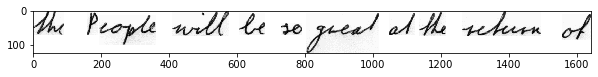

In [29]:
sample, label = X_train[0], y_train[0]
img = mpimg.imread(sample)
plt.figure(figsize = (10,10))
plt.imshow(img, cmap ='gray')
print("Label: ", label)

In [42]:
images, labels = get_augmented_sample(sample, label, 0.05)

[34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34]


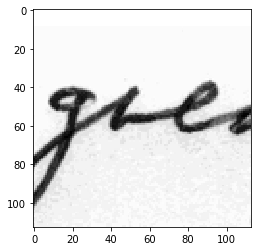

In [43]:
print(labels)
plt.imshow(images[1], cmap ='gray')